# DMOV
En este notebook voy a constuir un detector de movimiento,el cual esta basado en la diferencia entre una imagen
que sera el fondo y las imagenes de la camara en vivo.

In [1]:
import numpy             as np
import cv2               as cv
from matplotlib.pyplot import imshow, subplot, title
from umucv.stream import Camera
import ipywidgets
%matplotlib inline

Cargamos el fondo y un fotograma cualquiera de la camara en vivo.

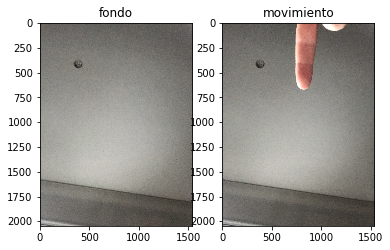

In [19]:
fondo = cv.cvtColor(cv.imread("../img/DMOV/fondo.JPEG"),cv.COLOR_BGR2RGB)
movimiento = cv.cvtColor(cv.imread("../img/DMOV/movimiento.JPEG"),cv.COLOR_BGR2RGB)

subplot(1,2,1); imshow(fondo); title('fondo');

subplot(1,2,2); imshow(movimiento); title('movimiento');


Una alta resolucion no mejora la detecion es mas puede introducir artefactos y hacer que tengamos que bajar la sensibilidad
de nuestro detector es por eso que la reducimos y aplicamos un filtro gausiano con el cual
esperamos reducir el numero de artefactos.
Asi tenemos una imagen con menos detalles donde los movimientos se notan mas.

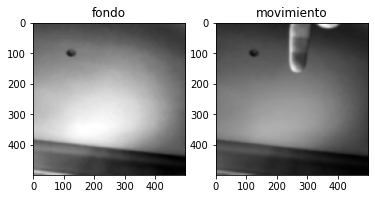

In [20]:
def aplica_filtros(img):
    frame = cv.resize(img, (500, 500), interpolation=cv.INTER_AREA)
    gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
    gray = cv.GaussianBlur(gray, (21, 21), 0)
    return gray

gray_fondo = aplica_filtros(fondo)
gray_movimiento = aplica_filtros(movimiento)

subplot(1,2,1); imshow(gray_fondo,'gray'); title('fondo');
subplot(1,2,2); imshow(gray_movimiento,'gray'); title('movimiento');


Una vez tengamos nuestro fondo listo solo tenemos que capturar la diferencia entre los frames,
aplicar un threshold para definir mas la imagen y finalmente capturar los contornos

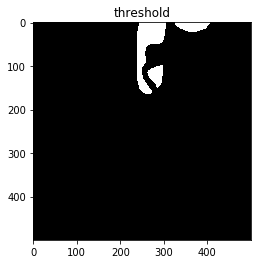

In [21]:
def capture_contours(fondo, actual):
    """
    Detecta movimiento sobre un fondo y devuelve el contorno del los objetos con movimiento.
    Args:
        fondo: Imagen de fondo
        actual: Imagen actual

    Returns:
        contours :Devuelve los contornos del objeto

    """
    # calculamos la diferencia entre frames
    frameDelta = cv.absdiff(fondo, actual)
    # Aplicamos un threshold es decir si el pixel tiene valor menor que 25 lo ponemos negro
    # Si tiene mayor igual que 25 lo ponemos a blanco.
    thresh = cv.threshold(frameDelta, 25, 255, cv.THRESH_BINARY)[1]
    #cv.imshow('threshold', thresh)
    imshow(thresh,"gray");title('threshold')
    #cv.waitKey(1)
    # Hacemos los puntos blancos "mas gordos" para poder pillar mejores contornos
    #
    thresh = cv.dilate(thresh, None, iterations=2)
    # Solo necesitamos los contornos mas grandes
    contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    return contours

contours = capture_contours(gray_fondo,gray_movimiento)

Una vez tenemos los contronos calculamos su area y si es lo suficientemente grande se ha producido movimiento.

In [22]:
def calculate_movement(t_value):
    img_save = gray_movimiento.copy()
    estado_moviento = "ALL CLEAR"
    for c in contours:
        # Si el contorno es muy pequeño lo ignoramos
        if cv.contourArea(c) < t_value:
            continue
        # Creamos un recuadro al rededor del contorno
        (x, y, w, h) = cv.boundingRect(c)
        cv.rectangle(img_save, (x, y), (x + w, y + h), (0, 255, 0), 2)
        estado_moviento = "MOVIMIENTO DETECTADO"

    imshow(img_save,'gray'); title('movimiento');
    print(estado_moviento)


ipywidgets.interactive(calculate_movement, t_value=(0,10000))

interactive(children=(IntSlider(value=5000, description='t_value', max=10000), Output()), _dom_classes=('widge…

<video controls src="../img/DMOV/Videodmov-1.m4v" />

